이 노트북은 김성훈 교수님의 모두를 위한 딥러닝 강좌 스크립트들을 참고, 재구성하여 만들어졌습니다.


(https://github.com/hunkim/DeepLearningZeroToAll/tree/master/tf2)

필요한 모듈들을 import합니다.

In [ ]:
import tensorflow as tf
# 텐서플로우 패키지
import tensorflow.keras.backend as K
# Low-Level API 패키지
import random
# 재현성을 위해 난수 Seed를 고정하기 위해 불러오는 패키지입니다.
from tensorflow.keras.datasets.mnist import load_data

하이퍼 패러미터와 난수 Seed를 설정합니다.

In [ ]:
random.seed(777)
# 재현성을 위해 난수를 고정합니다.

# Hyperparameters
# 하이퍼 패러미터란 학습으로 인해 자동으로 최적화되는 값이 아닌,
# 사람이 Huristic하게 최적의 값을 찾아나갈 수 밖에 없는 Parameter들입니다.
learning_rate = 0.001
# 한번에 얼만큼 업데이트 할 것인가에 대한 Hyperparameter입니다.
training_epochs = 15
# 에폭은 전체 데이터셋의 크기 만큼의 한 Loop를 일컫는 단위입니다. 총 몇 에폭 돌지 설정합니다.
batch_size = 100
# 한번에 Feed하는 이미지의 갯수를 결정합니다.
# 초심자 단계에서 당장 신경쓸 필요는 없지만 배치사이즈는 학습속도 뿐만 아니라 최종적인 성능에도 상당한 영향을 미친다고 알려져 있습니다.
drop_rate = 0.3
# Dropout을 할 때 얼만큼 데이터를 탈락시킬 지 결정하는 Parameter입니다.
# (1 - drop_rate)만큼 학습시에 데이터를 보존합니다.
# 최신버전 텐서플로우는 Dropout layer의 인자로 keep_prob 대신 rate를 전달하도록 권장하고 있는데(Keyword 인자로 전달 시 여전히 keep_prob도 사용가능하긴 함)
# 아마 Dropout에 전달하는 Non-Keyword 인자로서 이쪽이 더 직관적이라고 생각한 듯 합니다.

MNIST 데이터셋은 텐서플로우에서 자체적으로 제공하므로 텐서플로우 API를 이용해 데이터를 불러온 뒤 데이터 로더를 만들어 줍니다.

Input을 1자로 펴주고, Label을 One-Hot 인코딩으로 전환해줍니다.

In [ ]:
(x_train, y_train), (x_test, y_test) = load_data()
# 텐서플로우에서 지원하는 API를 사용합니다.
# x_train, y_train 쌍은 학습 데이터셋의 Input, Label 쌍이고
# x_test, y_test 쌍은 평가 데이터셋의 Input, Label 쌍입니다.

x_train = x_train.reshape(x_train.shape[0], 28 * 28)
x_test = x_test.reshape(x_test.shape[0], 28 * 28)
# Fully Connected Layer에 Feed하기 위해 Input(이미지)을 1자로 펴줍니다.

y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)
# Label을 One-Hot 인코딩으로 전환해줍니다.

data_train = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(batch_size)
# DataLoader를 설정합니다.

11493376/11490434 [==============================] - 0s 0us/step


모델을 구성합니다. 딥러닝 소스코드의 심장에 해당하는 부분입니다.


단순 일방향 Feeding 구조를 가진 모델을 구현할 때는 텐서플로우의 Sequential API를 사용하면 매우 편리합니다.

In [ ]:
model = tf.keras.Sequential()
# tf.keras.Sequential API를 사용해 레이어들을 추가할 빈 신경망을 정의합니다.

# 텐서플로우 2.X에서는 Layer를 정의함과 동시에 Sequential.add를 통해 바로 추가할 수 있습니다.
model.add(tf.keras.layers.Dense(input_dim=784, units=512, kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.05), use_bias=True, activation='relu'))
# 입력이 784 채널, 출력이 512 채널이고, Bias가 있으며, 활성화함수로 relu를 사용하는 Layer를 정규분포에서 초기화합니다.
# Bias들은 별도로 지정하지 않으면 0으로 초기화됩니다.

model.add(tf.keras.layers.Dropout(drop_rate))
# Regularization을 위해 Dropout을 정의, 추가합니다.

# 위와 같은 방식으로 나머지 부분의 신경망을 정의, 추가합니다.
model.add(tf.keras.layers.Dense(units=512, kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.05), use_bias=True, activation='relu'))
model.add(tf.keras.layers.Dropout(drop_rate))
model.add(tf.keras.layers.Dense(units=512, kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.05), use_bias=True, activation='relu'))
model.add(tf.keras.layers.Dropout(drop_rate))
model.add(tf.keras.layers.Dense(units=512, kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.05), use_bias=True, activation='relu'))
model.add(tf.keras.layers.Dropout(drop_rate))
model.add(tf.keras.layers.Dense(units=10, kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.05), use_bias=True, activation=None))
# 마지막 Layer의 활성화함수로는 SoftMax를 사용합니다.

criterion = tf.keras.losses.categorical_crossentropy
# Loss Function을 정의합니다. 
# Criterion = 척도 (Objective Function으로 직접 사용할 수 있는 척도)
# Metric = 척도 (Objective Function으로 직접 사용할 수 있을 수도 있고 없을 수도 있음)

optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
# 최적화엔 Adam Optimizer를 사용합니다.
# model.parameters()로 Model에 등록된 학습가능한 모든 Parameter들을 불러오고
# learning_rate = learning_rate로 Hyperparameter인 Learning Rate를 입력해줍니다.

model.summary()
# 정의한 모델을 한 번 출력해봅니다.

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               401920    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               2

텐서플로우는 단일 GPU이고 텐서플로우 GPU버전이 설치되어 있을 경우, 별도의 코드 추가 없이도 자동으로 GPU 가속이 적용됩니다.

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()
# GPU가 사용가능한지만 확인해줍니다.

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 8937821572675027978, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 2982824834292927545
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 11359926252491882269
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11150726272
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 11788245293122063356
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

텐서플로우 2.X에서는 일반적으로 직접 트레이닝 루프를 코딩할 필요가 없지만, 복잡한 Metric을 매 루프마다 확인하고 싶거나, 매 루프마다 특별한 처리가 필요할 때(주로 시계열 모델에서) 직접 트레이닝 루프를 코딩해야 할 필요가 있습니다. 


텐서플로우 2.X의 트레이닝 루프 파이프라인은 파이토치와 매우 흡사합니다.

In [ ]:
for epoch in range(training_epochs):
  avg_cost = 0
  total_batch = len(x_train) // batch_size
  # '전체 데이터셋 길이'를 '한번에 Feed하는 배치사이즈'로 나누면
  # 한 에폭을 돌기위해 반복해야 할 루프횟수(total_batch)가 됩니다.

  for i, (batch_xs, batch_ys) in enumerate(data_train): 
    with tf.GradientTape() as tape:
      hypothesis = model(batch_xs, training=True)
      # hypothesis는 말 그대로 가설입니다. 내 모델을 통해 예측한 예측값(가설)이라고 생각하면 됩니다.
      # Softmax를 거치기 전 Logit도 가설이라고 할 수 있고 Softmax를 거친 확률 값도 가설이라고 할 수 있습니다.
      # training=True로 설정해서 Dropout을 적용하고
      # Batchnormalization 패러미터를 해당 배치에서 구해 이동평균법으로 갱신하는 등의 행동을 수행합니다.
      cost = K.mean(criterion(batch_ys, hypothesis, from_logits=True)) 
      # == cost = K.mean(K.sum(-1 * batch_ys * (hypothesis - K.log(K.tile(K.expand_dims(K.sum(K.exp(hypothesis), axis=1), axis=1), [1, 10]))), axis=1))
      # Loss Function을 거친 뒤 나온 '실제 정답값과의 차이'를 구합니다.

    grads = tape.gradient(cost, model.trainable_variables)
    # '실제 정답값과의 차이'를 모델에 속한 각 Variable들로 편미분한 값을 각 Variable에 전달하는 과정이 내부적으로 진행됩니다.
    
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    # 각 Variable에 등록된 grad를 이용해 Weight 값을 Adam Optimization 방법으로 업데이트합니다.
    
    avg_cost += cost / total_batch

  print("[Epoch: %7d] cost = %5.5f"%(epoch + 1, avg_cost))
  # '실제 정답값과의 차이'가 얼마나 줄어들었는지 실시간으로 확인합니다.

print('Learning Finished!')

[Epoch:       1] cost = 3.01749
[Epoch:       2] cost = 0.43125
[Epoch:       3] cost = 0.30616
[Epoch:       4] cost = 0.24884
[Epoch:       5] cost = 0.21975
[Epoch:       6] cost = 0.20080
[Epoch:       7] cost = 0.19027
[Epoch:       8] cost = 0.19341
[Epoch:       9] cost = 0.18529
[Epoch:      10] cost = 0.18217
[Epoch:      11] cost = 0.18019
[Epoch:      12] cost = 0.18011
[Epoch:      13] cost = 0.17526
[Epoch:      14] cost = 0.17526
[Epoch:      15] cost = 0.15999
Learning Finished!


학습이 완료된 모델을 이용해 정확도(Accuracy)를 구해봅니다.

In [ ]:
hypothesis = model(x_test, training=False)
# training=False로 모델을 Evaluation 모드로 바꿔줍니다.
# Batchnormalization 패러미터를 이동평균으로 바꿔주거나 Dropout을 없애주는 등의 역할을 수행합니다.
# 만약 이 함수로 인해 영향받지 않는 Layer를 만들고 싶다면 tf.keras.backend 패키지를 사용합니다.

correct_prediction = tf.keras.backend.equal(tf.keras.backend.argmax(hypothesis, 1), tf.keras.backend.argmax(y_test, 1))

accuracy = tf.keras.backend.mean(tf.cast(correct_prediction, tf.float32))
# Bool형식 데이터를 Float형식으로 바꾼 뒤 전체의 평균을 취하면 정확도를 구할 수 있습니다.
print('Accuracy:', accuracy.numpy())
# 정확도를 출력합니다.

Accuracy: 0.9703


모델이 잘 작동하는지 예시 하나를 직접 눈으로 확인합니다

In [ ]:
import numpy as np

random_index = random.randint(0, x_test.shape[0]-1)
# 랜덤한 인덱스를 하나 뽑습니다.

hypothesis = model(tf.keras.backend.expand_dims(x_test[random_index], axis=0), training=False)
# training=False로 모델을 Evaluation 모드로 바꿔줍니다.

print("Index: ", random_index)
print("Label: ", np.argmax(y_test[random_index]))
print("Prediction: ", np.argmax(hypothesis))
# 예측값과 정답을 비교해봅니다.

Index:  3757
Label:  8
Prediction:  8


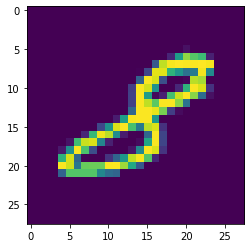

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(np.squeeze(x_test[random_index].reshape(28, 28)))
# 예측에 사용했던 숫자의 이미지를 시각화 해봅니다.

위 과정을 모두 완료하셨으면 오버피팅 현상을 경험해보기 위해 학습을 더 시키고 정확도를 확인해 봅시다.